## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-09-17 20:02:18.277281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 20:02:18.277314: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Controllable hyperparameters

In [87]:
# We can use these to slice a pandas datetime index
warmup_start = '20210401'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

# How long can a person take to progress?
transition_window = 20

# CovidEstim Hyper param
T_serial = 5.8

# Vaccines are 90% effective at preventing infection
# according to a study of 4000 healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7013e3.htm
vax_asymp_risk = 0.90
# Vaccines are 94% effective at preventing symptomatic
# according to a study of healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7020e2.htm
vax_mild_risk = 0.94
vax_extreme_risk = 0.94
# Vaccines are 94% effective at preventing hospitalization
# according to a study of adults over 65 early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7018e1.htm?s_cid=mm7018e1_w
vax_general_ward_risk = 0.94

# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G

# Copied from covid estim
# covidestim infected -> symptoms
alpha_bar_M = 5.5
beta_bar_M = 3.53
# covidestim symptoms -> severe
alpha_bar_X = 1.89
beta_bar_X = 20
# covid estim severe -> death
alpha_bar_G = 28.2
beta_bar_G = 162.3

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so +
# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days

# We choose these values to match the gamma priors in covid estim
# Covidestim infected -> symptoms = Gamma(3.41, 0.61)
lambda_bar_M = 4.7
sigma_bar_M = 1.00
nu_bar_M = 1.70
tau_bar_M = 0.10

# Covidestim Symptoms -> severe = Gamma(1.72, 0.22)
lambda_bar_X = 4
sigma_bar_X = 0.5
nu_bar_X = 18
tau_bar_X = 8.1

# Covidestim severe -> death = Gamma(2.10, 0.23)
lambda_bar_G = 3.3
sigma_bar_G = 1
nu_bar_G = 9
tau_bar_G = 0.2


# Learning rate
learning_rate = 1e-1


## Model size globals


In [88]:
# Globals are ugly
# could create an enum or make them properties of a model class or something
COMPARTMENTS = 4
ASYMP = 0
MILD = 1
EXTREME = 2
GENERAL_WARD = 3

## Create Warmup Data

In [89]:
# Local data folder containing downloads from OWID, HHS, and CovidEstim
# Filenames are the date the data was accessed
data_dir = './data'

covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

covid_estim_path = os.path.join(data_dir,'covidestim', covid_estim_date+'.csv')
hhs_path = os.path.join(data_dir,'hhs', hhs_date+'.csv')
owid_path = os.path.join(data_dir,'owid', owid_date+'_vaccinations.csv')




### Read CovidEstim


In [90]:
# Read covid estim
covid_estim = pd.read_csv(covid_estim_path)
# filter to state
covid_estim = covid_estim[covid_estim['state']==state]
# Make sure date is unique
assert len(covid_estim)==len(covid_estim.date.unique())

# create datetime index
covid_estim.loc[:, 'date'] = pd.to_datetime(covid_estim['date'])
covid_estim = covid_estim.set_index('date').sort_index()
# Rename to match our compartments
covid_estim = covid_estim.rename(columns={'infections':'asymp',
                                          'severe':'extreme',
                                          'symptomatic':'mild'
                                          })


### Read HHS for outcome variable

In [91]:
hhs = pd.read_csv(hhs_path)
hhs = hhs[hhs['state']==state_abbrev]
assert len(hhs) == len(hhs.date.unique())

# we have previous day admissions, so add 1 to date
hhs.loc[:, 'date'] = pd.to_datetime(hhs['date']) + pd.DateOffset(days=1)
hhs = hhs.set_index('date').sort_index()
hhs = hhs.rename(columns={'previous_day_admission_adult_covid_confirmed':'general_ward'})


### Read Our World In Data for a clean CDC state-level vaccine timeseries

In [92]:
owid = pd.read_csv(owid_path)
owid = owid[owid['location']==state]
owid.loc[:, 'date'] = pd.to_datetime(owid['date'])
owid = owid.set_index('date').sort_index()
# There are NaN's in the vaccine timeseries, so linearly interpolate
owid.loc[:, 'people_fully_vaccinated_per_hundred'] = owid[['people_fully_vaccinated_per_hundred']].interpolate(method='linear')
owid['vax_pct'] = owid[['people_fully_vaccinated_per_hundred']]*0.01

### Merge all warmup data together on the common date index

In [93]:
df = pd.merge(hhs[['general_ward']],
              covid_estim[['asymp','extreme','mild', 'Rt']],
              how='outer',
              left_index=True, right_index=True).merge(owid[['vax_pct']], how='outer', left_index=True, right_index=True)


### Create arrays of warmup data

In [94]:
warmup_infected = {}
warmup_asymp = {}
warmup_mild = {}
warmup_extreme = {}

not_vaxxed=0
vaxxed=1

# vaccines protect from infection/asymp/mild/extreme/general
# multiply population vaccinated by (1-protection %) to get vaccinated
warmup_asymp[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_asymp_risk) * \
                           df.loc[warmup_start:warmup_end, 'asymp']).values
warmup_asymp[not_vaxxed] = df.loc[warmup_start:warmup_end, 'asymp'].values - warmup_asymp[vaxxed]

warmup_mild[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_mild_risk) * \
                           df.loc[warmup_start:warmup_end, 'mild']).values
warmup_mild[not_vaxxed] = df.loc[warmup_start:warmup_end, 'mild'].values - warmup_mild[vaxxed]

warmup_extreme[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_extreme_risk) * \
                           df.loc[warmup_start:warmup_end, 'extreme']).values
warmup_extreme[not_vaxxed] = df.loc[warmup_start:warmup_end, 'extreme'].values - warmup_extreme[vaxxed]

warmup_infected[vaxxed] = warmup_asymp[vaxxed] + warmup_mild[vaxxed] + warmup_extreme[vaxxed]
warmup_infected[not_vaxxed] = warmup_asymp[not_vaxxed] + warmup_mild[not_vaxxed] + warmup_extreme[not_vaxxed]

training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

# Start the model from the training period so we are continuous
testing_rt = df.loc[train_start:test_end,'Rt'].values
testing_general_ward = df.loc[train_start:test_end,'general_ward'].values


## Define The Model

In [95]:
class CovidModel(tf.keras.Model):
    
    def __init__(self, transition_window, T_serial,
                 alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G,
                 compartments=COMPARTMENTS):
        """Covid Model 1.5
        
        Args:
            transition_window (int): J in our notation, the number of days to consider a 
                possible transition to a more severe state
            T_serial (float): CovidEstim infection hyperparameter
            alpha_bar_M (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_M,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            beta_bar_M (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_M,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            alpha_bar_X (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_X,
                the likelihood that an individual with Mild symptoms progresses to the eXtreme state
            beta_bar_X (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_X,
                the likelihood that an individual with Mild symptoms progresses to the eXtreme state
            alpha_bar_G (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_G,
                the likelihood that an individual with eXtreme symptoms progresses to the hospital
            beta_bar_G (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_G,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            lambda_bar_M (float): The mean of a strictly-positive Normal distribution prior over lambda_M, the rate
                of the Poisson distribution that governs how quickly individuals transition from Asymptomatic to Mild
            sigma_bar_M (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_M,
                the rate of the Poisson distribution that governs how quickly individuals transition from Asymptomatic to Mild
            lambda_bar_X (float): The mean of a strictly-positive Normal distribution prior over lambda_X, the rate
                of the Poisson distribution that governs how quickly individuals transition from Mild to eXtreme
            sigma_bar_X (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_X,
                the rate of the Poisson distribution that governs how quickly individuals transition from Mild to eXtreme
            lambda_bar_G (float): The mean of a strictly-positive Normal distribution prior over lambda_G, the rate
                of the Poisson distribution that governs how quickly individuals transition from eXtreme to the General ward
            sigma_bar_G (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_G,
                the rate of the Poisson distribution that governs how quickly individuals transition from eXtreme to the General Ward
            nu_bar_M (float): The mean of a strictly-positive Normal distribution prior over nu_M, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_M (float): The standard deviation of a strictly-positive Normal distribution prior over nu_M, 
                which scales the poisson PMF used to determine progression to the next state
            nu_bar_X (float): The mean of a strictly-positive Normal distribution prior over nu_X, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_X (float): The standard deviation of a strictly-positive Normal distribution prior over nu_X, 
                which scales the poisson PMF used to determine progression to the next state
            nu_bar_G (float): The mean of a strictly-positive Normal distribution prior over nu_G, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_G (float): The standard deviation of a strictly-positive Normal distribution prior over nu_G, 
                which scales the poisson PMF used to determine progression to the next state
        """
        super(CovidModel, self).__init__()
        
        self.transition_window = transition_window
        self.T_serial = T_serial
        self.compartments = compartments
        
        # create dictionaries to store model parameters / prior distributions
        self._initialize_parameters(lambda_bar_M, lambda_bar_X, lambda_bar_G,
                                    nu_bar_M, nu_bar_X, nu_bar_G)
        self._initialize_priors(alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                                lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                                nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G)
        
    
    def call(self, inputs, debug_disable_prior=False, return_all=False):
        """Run covid model 1.5
        
        Args:
            inputs (tuple(tf.Tensor)): A tuple of all input tensors we need. It should be, in order:
                (rt,
                 warmup_asymp_not_vaxxed, warmup_asymp_vaxxed,
                 warmup_mild_not_vaxxed, warmup_mild_vaxxed,
                 warmup_extreme_not_vaxxed, warmup_extreme_vaxxed)
                rt should be size (1, days_to_forecast), while
                warmup data should be size (1, days_of_warmup)
            debug_disable_prior (bool): If True, will disable adding the prior to the loss. Used to debug gradients
        Returns:
            tf.Tensor: A tensor size (1, days_to_forecast) of incident hospital admissions
        """
        
        # Tensorflow models are typically a single tensor or a tuple of multiple tensors
        # This function accepts all the input tensors we need (r_t, warmup for AMX, both vaxxed and non-vaxxed)
        # and returns r_t, along with dictionaries keyed on vaccination status for easier use.
        r_t, warmup_asymp, warmup_mild, warmup_extreme = self._parse_inputs(inputs)
        
        # We need to know how long the warmup data is and how long to forecast for
        # Take the last dimension one of the warmup data tensors
        # Any will do, so we arbitrariliy pick the vax_status=0 asymptomatic
        warmup_days_val = warmup_asymp[0].shape[-1]
        # take the last dimension of r_t
        forecast_days_val = r_t.shape[-1]
        
        # It's a little weird to iteratively write to tensors one day at a time
        # To do this, we'll use TensorArray's, arrays of tensors where each element is a tensor representing
        # one compartment/vaccine status/ day
        # This helper function creates a nested dictionary keyed on:
        #  compartment-> 
        #      vaccinestatus->
        #           TensorArray with one tensor per day from:
        #               warmup_start to forecast_end for any quantities with warmup data
        #               forecast_start to forecast_end for the outcome, which does not have warmup data
        forecasted_fluxes = self._initialize_flux_arrays(warmup_asymp, warmup_mild, warmup_extreme,
                                                         warmup_days_val, forecast_days_val)
        
        # Our model parameters have several constraints (being between 0-1, being positive)
        # So we need to transform them from the unconstrained space they are modeled in
        # This call transforms them and saves them properties of this model object (self):
        #     epsilon, a scalar with value between 0-1
        #     delta, a dictionary of scalars keyed on vaccination status with values between 0-1
        #     rho_M, rho_X, rho_G: dictionaries of tensors keyed on vaccination status with values between 0-1
        #     lambda_M,  lambda_X, lambda_G: dictionaries of positive-valued tensors keyed on vaccination status
        #     nu_M, nu_X, nu_G: dictionaries of positive-valued tensors keyed on vaccination status
        #     poisson_M, poisson_X, poisson_G: dictionaries of probability distribution objects keyed on vaccine status
        #     pi_M, pi_X, pi_G: dictionaries of tensor arrays with 1 element for each of the past J days
        #     previously_asymptomatic, previously_mild, previously_extreme: dictionaries of tensor arrays with 1 element for each of the past J days
        
        self._constrain_parameters()
        
        if not debug_disable_prior:
            self._add_prior_loss()

        # forecast from the end of warmup to the end of forecasting
        for day in range(warmup_days_val, forecast_days_val+warmup_days_val):
            
            # Start with asymptomatic
            asymp_t_1_no_vax = forecasted_fluxes[ASYMP][0].read(day-1)
            asymp_t_1_vax = forecasted_fluxes[ASYMP][1].read(day-1)
            combined_asymp_covariate = asymp_t_1_no_vax + self.epsilon * asymp_t_1_vax
            
            

            for vax_status in range(2):
                
                forecasted_fluxes[ASYMP][vax_status]  = forecasted_fluxes[ASYMP][vax_status].write(day,
                    tf.squeeze(combined_asymp_covariate * self.delta[vax_status] * r_t[day-warmup_days_val]** (1/self.T_serial))
                )

                # get last J days of AMX
                for j in range(self.transition_window):
                    self.previously_asymptomatic[vax_status] = self.previously_asymptomatic[vax_status].write(j,
                        forecasted_fluxes[ASYMP][vax_status].read(day-(j+1)))

                    self.previously_mild[vax_status] = self.previously_mild[vax_status].write(j,
                        forecasted_fluxes[MILD][vax_status].read(day-(j+1)))
                    self.previously_extreme[vax_status] = self.previously_extreme[vax_status].write(j,
                        forecasted_fluxes[EXTREME][vax_status].read(day-(j+1)))                    
                
                previously_asymptomatic_tensor = self.previously_asymptomatic[vax_status].stack()
                previously_mild_tensor = self.previously_mild[vax_status].stack()
                previously_extreme_tensor = self.previously_extreme[vax_status].stack()
               
                forecasted_fluxes[MILD][vax_status]  = forecasted_fluxes[MILD][vax_status].write(day,
                    tf.reduce_sum(previously_asymptomatic_tensor * self.rho_M[vax_status] * self.pi_M[vax_status], axis=0)
                )
                     
                forecasted_fluxes[EXTREME][vax_status]  = forecasted_fluxes[EXTREME][vax_status].write(day,
                    tf.reduce_sum(previously_mild_tensor * self.rho_X[vax_status] * self.pi_X[vax_status], axis=0)
                )
                    
                forecasted_fluxes[GENERAL_WARD][vax_status]  = forecasted_fluxes[GENERAL_WARD][vax_status].write(day-warmup_days_val,
                    tf.reduce_sum(previously_extreme_tensor * self.rho_G[vax_status] * self.pi_G[vax_status], axis=0)
                )

                
        # Re-combine vaccinated and unvaxxed for our output
        if return_all:
            result = forecasted_fluxes
        else:
            result = forecasted_fluxes[GENERAL_WARD][0].stack()+ forecasted_fluxes[GENERAL_WARD][1].stack()
        
        # Tensorflow thinks we didn't use every array, so we gotta mark them as used
        # TODO: did i screw up?
        self._mark_arrays_used(forecasted_fluxes)
            
        return result
    
    def _initialize_parameters(self, lambda_bar_M, lambda_bar_X, lambda_bar_G,
                               nu_bar_M, nu_bar_X, nu_bar_G):
        """Helper function to hide the book-keeping behind initializing model parameters
        
        TODO: Replace with better initializations
        """
        
        self.model_params = {}
        
        for compartment in range(self.compartments):
            self.model_params[compartment] = {}
            for vax_status in [0, 1]:
                self.model_params[compartment][vax_status] = {}
        
        self.unconstrained_eps = self.add_weight(shape=tf.TensorShape(1), initializer="random_normal", trainable=True, name=f'eps')
        self.unconstrained_delta = {}
        
        # Fix delta = 1 for non-vax 
        self.unconstrained_delta[0] = tf.Variable([1e8], name='A_delta_0', trainable=False)
        # TODO: debug
        # if this isn't add weight the gradient doesn't get tracked for some reason
        self.unconstrained_delta[1] = self.add_weight(shape=tf.TensorShape(1), initializer="random_normal",
                                                      trainable=True, name=f'A_delta_1')
        
        # initialize model parameters
        for vax_status in [0, 1]:
            
            self.model_params[MILD][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'M_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[MILD][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_M], name=f'M_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[MILD][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_M], name=f'M_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'X_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_X], name=f'X_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_X], name=f'X_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'G_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_G], name=f'G_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_G], name=f'G_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))


        return
    
    def _initialize_priors(self, alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                           lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                           nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G,
                           eps_delta_a=1.5, eps_delta_b=1.5):
        """Helper function to hide the book-keeping behind initializing model priors"""
        
        self.prior_distros = {}
        for compartment in range(self.compartments):
            self.prior_distros[compartment] = {}
            for vax_status in [0, 1]:
                self.prior_distros[compartment][vax_status] = {}
                
        # Tensorflow doesn't support dictionaries with mixed key types, so we'll give these a compartment and vax status
        self.prior_distros[ASYMP][0]['epsilon'] = tfp.distributions.Beta(eps_delta_a, eps_delta_b)
        self.prior_distros[ASYMP][1]['delta_1'] = tfp.distributions.Beta(eps_delta_a, eps_delta_b)
                
        # create prior distributions
        for vax_status in [0,1]:
            self.prior_distros[MILD][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_M, beta_bar_M)
            self.prior_distros[EXTREME][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_X, beta_bar_X)
            self.prior_distros[GENERAL_WARD][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_G, beta_bar_G)
            
            # We want these to be positive so we use a truncated normal with range 0-100
            self.prior_distros[MILD][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_M, sigma_bar_M, 0, 20)
            self.prior_distros[EXTREME][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_X, sigma_bar_X, 0, 20)
            self.prior_distros[GENERAL_WARD][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_G, sigma_bar_G, 0, 20)
            
            self.prior_distros[MILD][vax_status]['nu'] = tfp.distributions.TruncatedNormal(nu_bar_M, tau_bar_M, 0, 20)
            self.prior_distros[EXTREME][vax_status]['nu'] = tfp.distributions.TruncatedNormal(nu_bar_X, tau_bar_X, 0, 20)
            self.prior_distros[GENERAL_WARD][vax_status]['nu'] = tfp.distributions.Normal(nu_bar_G, tau_bar_G, 0, 20)
        
        return
    
    def _parse_inputs(self, inputs):
        """Helper function to hide the logic in parsing the big mess of input tensors we get"""
        (r_t,
         warmup_asymp_not_vaxxed, warmup_asymp_vaxxed,
         warmup_mild_not_vaxxed, warmup_mild_vaxxed,
         warmup_extreme_not_vaxxed, warmup_extreme_vaxxed) = inputs
        
        r_t = tf.squeeze(r_t)
        
        warmup_asymp = {}
        warmup_asymp[0] = tf.squeeze(warmup_asymp_not_vaxxed)
        warmup_asymp[1] = tf.squeeze(warmup_asymp_vaxxed)
        
        warmup_mild = {}
        warmup_mild[0] = tf.squeeze(warmup_mild_not_vaxxed)
        warmup_mild[1] = tf.squeeze(warmup_mild_vaxxed)
        
        warmup_extreme = {}
        warmup_extreme[0] = tf.squeeze(warmup_extreme_not_vaxxed)
        warmup_extreme[1] = tf.squeeze(warmup_extreme_vaxxed)
        
        return r_t, warmup_asymp, warmup_mild, warmup_extreme
        
    def _initialize_flux_arrays(self, warmup_asymp, warmup_mild, warmup_extreme,
                                warmup_days, forecast_days):
        """Helper function to hide the plumbing in creating TensorArrays for every output
        
        Args:
            warmup_days (int): Number of days of warmup data
            forecast_days (int): Number of days to forecast
        Returns
            dict{int:dict{int:TensorArray}}: Nested dictionary keyed on compartment->vaccine status,
                containing a TensorArray for every quantity
        """
        
        forecasted_fluxes = {}
        
        for compartment in range(self.compartments):
            forecasted_fluxes[compartment] = {}
            
            # No need to store warmup data for the outcome
            if compartment == GENERAL_WARD:
                array_size = forecast_days
            else:
                array_size = warmup_days + forecast_days
            
            for vax_status in range(2):
                forecasted_fluxes[compartment][vax_status] = tf.TensorArray(tf.float32, size=array_size,
                                                                            clear_after_read=False,
                                                                            name=f'{compartment}_{vax_status}')
                
        # Write the warmup data to the array so we don't have to look in two places:
        for day in range(warmup_days):
            for vax_status in range(2):
                forecasted_fluxes[ASYMP][vax_status] = \
                    forecasted_fluxes[ASYMP][vax_status].write(day,
                                                                  warmup_asymp[vax_status][day])
                forecasted_fluxes[MILD][vax_status] = \
                    forecasted_fluxes[MILD][vax_status].write(day,
                                                                  warmup_mild[vax_status][day])
                forecasted_fluxes[EXTREME][vax_status] = \
                    forecasted_fluxes[EXTREME][vax_status].write(day,
                                                                  warmup_extreme[vax_status][day])

        return forecasted_fluxes
    
    def _constrain_parameters(self):
        """Helper function to hide the plumbing of creating the constrained parameters and other model TensorArrays"""
        
        # Must be 0-1
        self.epsilon = tf.math.sigmoid(self.unconstrained_eps)
        
        self.delta = {}
        for vax_status in range(2):
            self.delta[vax_status] = tf.squeeze(tf.math.sigmoid(self.unconstrained_delta[vax_status]))
        
        # Initialize dictionaries keyed on vax status
        self.rho_M = {}
        self.rho_X = {}
        self.rho_G = {}
        self.lambda_M = {}
        self.lambda_X = {}
        self.lambda_G = {}
        self.nu_M = {}
        self.nu_X = {}
        self.nu_G = {}
        self.poisson_M = {}
        self.poisson_X = {}
        self.poisson_G = {}
        self.pi_M = {}
        self.pi_X = {}
        self.pi_G = {}

        self.previously_asymptomatic = {}
        self.previously_mild = {}
        self.previously_extreme = {}

        for vax_status in range(2):

            # Rho must be 0-1, so use sigmoid
            # lambda and nu must be positive, so use softplus
            self.rho_M[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[MILD][vax_status]['unconstrained_rho']))
            self.lambda_M[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[MILD][vax_status]['unconstrained_lambda']))
            self.nu_M[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[MILD][vax_status]['unconstrained_nu']))

            self.rho_X[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[EXTREME][vax_status]['unconstrained_rho']))
            self.lambda_X[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[EXTREME][vax_status]['unconstrained_lambda']))
            self.nu_X[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[EXTREME][vax_status]['unconstrained_nu']))

            self.rho_G[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[GENERAL_WARD][vax_status]['unconstrained_rho']))
            self.lambda_G[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[GENERAL_WARD][vax_status]['unconstrained_lambda']))
            self.nu_G[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[GENERAL_WARD][vax_status]['unconstrained_nu']))

            # Create the distributions for each compartment
            self.poisson_M[vax_status] = tfp.distributions.Poisson(rate=self.lambda_M[vax_status])
            self.poisson_X[vax_status] = tfp.distributions.Poisson(rate=self.lambda_X[vax_status])
            self.poisson_G[vax_status] = tfp.distributions.Poisson(rate=self.lambda_G[vax_status])

            # pi is fixed while we forecast so we can create that now
            self.pi_M[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_M')
            self.pi_X[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_X')
            self.pi_G[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_G')
            for j in range(self.transition_window):
                self.pi_M[vax_status] = self.pi_M[vax_status].write(j, self.poisson_M[vax_status].log_prob(j+1)/self.nu_M[vax_status])
                self.pi_X[vax_status] = self.pi_X[vax_status].write(j, self.poisson_X[vax_status].log_prob(j+1)/self.nu_X[vax_status])
                self.pi_G[vax_status] = self.pi_G[vax_status].write(j, self.poisson_G[vax_status].log_prob(j+1)/self.nu_G[vax_status])

            # stacking the TensorArray makes it a tensor again
            self.pi_M[vax_status] = tf.transpose(self.pi_M[vax_status].stack())
            # Softmax so it sums to 1
            self.pi_M[vax_status] = tf.nn.softmax(self.pi_M[vax_status])

            self.pi_X[vax_status] = tf.transpose(self.pi_X[vax_status].stack())
            self.pi_X[vax_status] = tf.nn.softmax(self.pi_X[vax_status])
            self.pi_G[vax_status] = tf.transpose(self.pi_G[vax_status].stack())
            self.pi_G[vax_status] = tf.nn.softmax(self.pi_G[vax_status])

            # Initialize tensor arrays for storing these values
            self.previously_asymptomatic[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False, name=f'prev_asymp')
            self.previously_mild[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name=f'prev_mild')
            self.previously_extreme[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False, name=f'prev_extreme')

    def _add_prior_loss(self):
        """Helper function for adding loss from model prior"""
        # only 1 epsilon
        # Not sure why only this one needs to get squeezed
        self.add_loss(tf.squeeze(-self.prior_distros[ASYMP][0]['epsilon'].log_prob(self.epsilon)))
        # delta_0 is fixed
        self.add_loss(-self.prior_distros[ASYMP][1]['delta_1'].log_prob(self.delta[1]))
        
        for vax_status in range(2):
            # Add losses from param priors
            # Make everything negative because we're minimizing
            self.add_loss(-self.prior_distros[MILD][vax_status]['rho'].log_prob(self.rho_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['rho'].log_prob(self.rho_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['rho'].log_prob(self.rho_G[vax_status]))

            self.add_loss(-self.prior_distros[MILD][vax_status]['lambda'].log_prob(self.lambda_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['lambda'].log_prob(self.lambda_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['lambda'].log_prob(self.lambda_G[vax_status]))
            
            self.add_loss(-self.prior_distros[MILD][vax_status]['nu'].log_prob(self.nu_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['nu'].log_prob(self.nu_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['nu'].log_prob(self.nu_G[vax_status]))
            
    def _mark_arrays_used(self, forecasted_fluxes):
        """Helper function that supresses noisy error about not using all arrays"""
        for vax_status in range(2):
            forecasted_fluxes[ASYMP][vax_status].mark_used()
            forecasted_fluxes[MILD][vax_status].mark_used()
            forecasted_fluxes[EXTREME][vax_status].mark_used()
            forecasted_fluxes[GENERAL_WARD][vax_status].mark_used()
            self.previously_asymptomatic[vax_status].mark_used()
            self.previously_mild[vax_status].mark_used()
            self.previously_extreme[vax_status].mark_used()
            
        return



In [96]:
model = CovidModel(transition_window, T_serial,
                     alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_X, tau_bar_X)

In [99]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)

# Custom LogPoisson Probability Loss function
def calc_poisson(inputs):
    true_rate, predicted_rate = inputs
    poisson = tfp.distributions.Poisson(rate=true_rate)
    return poisson.log_prob(predicted_rate)

class LogPoissonProb(tf.keras.losses.Loss):
    


    def call(self, y_true, y_pred):
        log_probs = tf.map_fn(calc_poisson, (tf.squeeze(y_true), y_pred), fn_output_signature=tf.float32)
        # return negative log likielihood
        return -tf.reduce_sum(log_probs)
    
loss = LogPoissonProb()

class VarLogCallback(tf.keras.callbacks.Callback):
    """Logs all our model parameters"""

    def __init__(self, every_nth_epoch=1):
        self.every_nth_epoch = every_nth_epoch

    def on_epoch_end(self, epoch, logs):

        if epoch % self.every_nth_epoch != 0:
            return

        for vax_status in [0, 1]:
            tf.summary.scalar(f'rho_M_{vax_status}',data=tf.squeeze(self.model.rho_M[vax_status]),step=epoch)
            tf.summary.scalar(f'rho_X_{vax_status}',data=tf.squeeze(self.model.rho_X[vax_status]),step=epoch)
            tf.summary.scalar(f'rho_G_{vax_status}',data=tf.squeeze(self.model.rho_G[vax_status]),step=epoch)
            
            tf.summary.scalar(f'lambda_M_{vax_status}',data=tf.squeeze(self.model.lambda_M[vax_status]),step=epoch)
            tf.summary.scalar(f'lambda_X_{vax_status}',data=tf.squeeze(self.model.lambda_X[vax_status]),step=epoch)
            tf.summary.scalar(f'lambda_G_{vax_status}',data=tf.squeeze(self.model.lambda_G[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_M_{vax_status}',data=tf.squeeze(self.model.nu_M[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_X_{vax_status}',data=tf.squeeze(self.model.nu_X[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_G_{vax_status}',data=tf.squeeze(self.model.nu_G[vax_status]),step=epoch)
            
            tf.summary.scalar(f'delta_{vax_status}',data=tf.squeeze(self.model.delta[vax_status]),step=epoch)

        tf.summary.scalar(f'eps',data=tf.squeeze(self.model.epsilon),step=epoch)
        
       
        return
    
log_dir = '/mnt/c/Users/kheut/logs/model_1_5_test_3/'
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

logging_callback= VarLogCallback()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)

2021-09-17 20:42:32.746228: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-17 20:42:32.746282: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-17 20:42:32.746347: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-17 20:42:32.746626: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-17 20:42:32.746654: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [100]:
model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp[0]]), np.asarray([warmup_asymp[1]]),
       np.asarray([warmup_mild[0]]), np.asarray([warmup_mild[1]]),
       np.asarray([warmup_extreme[0]]), np.asarray([warmup_extreme[1]])),
             y=np.asarray([training_general_ward]),
         epochs=500, batch_size=0, callbacks=[logging_callback, tensorboard_callback])

Epoch 1/500
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/training.py", line 835, in run_step
    outputs = model.train_step(data)  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/training.py", line 789, in train_step
    y, y_pred, sample_weight, regularization_losses=self.losses)  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1046, in __call__
    return outputs  File "/tmp/ipykernel_1598/3683216289.py", line 144, in call
    forecasted_fluxes[MILD][vax_status].read(day-(j+1)))  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py

2021-09-17 20:42:34.190605: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-17 20:42:34.190634: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-17 20:42:34.190679: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 1527290.6250

2021-09-17 20:42:35.134869: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-17 20:42:35.135779: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-17 20:42:35.179156: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-17 20:42:35.259270: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-17 20:42:35.540763: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_20_42_35



1/1 [==============================] - 2s 2s/step - loss: 1527290.6250


2021-09-17 20:42:35.785508: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_20_42_35/MrChipsNVME.trace.json.gz
2021-09-17 20:42:35.855304: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_20_42_35

2021-09-17 20:42:35.857178: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_20_42_35/MrChipsNVME.memory_profile.json.gz
2021-09-17 20:42:35.871745: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_20_42_35
Dumped tool data for xplane.pb to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_20_42_

Epoch 3/500
1/1 [==============================] - 1s 898ms/step - loss: 558727.8750
Epoch 4/500
1/1 [==============================] - 1s 899ms/step - loss: 248330.8750
Epoch 5/500
1/1 [==============================] - 1s 883ms/step - loss: 126976.5156
Epoch 6/500
1/1 [==============================] - 1s 872ms/step - loss: 71973.7422
Epoch 7/500
1/1 [==============================] - 1s 906ms/step - loss: 44126.2812
Epoch 8/500
1/1 [==============================] - 1s 878ms/step - loss: 28778.2832
Epoch 9/500
1/1 [==============================] - 1s 961ms/step - loss: 19735.8965
Epoch 10/500
1/1 [==============================] - 1s 872ms/step - loss: 14115.6201
Epoch 11/500
1/1 [==============================] - 1s 868ms/step - loss: 10466.0879
Epoch 12/500
1/1 [==============================] - 1s 879ms/step - loss: 8008.6577
Epoch 13/500
1/1 [==============================] - 1s 873ms/step - loss: 6302.5654
Epoch 14/500
1/1 [==============================] - 1s 870ms/step - los

1/1 [==============================] - 1s 872ms/step - loss: 997.4524
Epoch 101/500
1/1 [==============================] - 1s 984ms/step - loss: 996.9150
Epoch 102/500
1/1 [==============================] - 1s 861ms/step - loss: 996.3765
Epoch 103/500
1/1 [==============================] - 1s 863ms/step - loss: 995.8385
Epoch 104/500
1/1 [==============================] - 1s 863ms/step - loss: 995.2997
Epoch 105/500
1/1 [==============================] - 1s 879ms/step - loss: 994.7605
Epoch 106/500
1/1 [==============================] - 1s 886ms/step - loss: 994.2205
Epoch 107/500
1/1 [==============================] - 1s 889ms/step - loss: 993.6794
Epoch 108/500
1/1 [==============================] - 1s 921ms/step - loss: 993.1389
Epoch 109/500
1/1 [==============================] - 1s 1s/step - loss: 992.5964
Epoch 110/500
1/1 [==============================] - 1s 882ms/step - loss: 992.0532
Epoch 111/500
1/1 [==============================] - 1s 900ms/step - loss: 991.5099
Epoch 112

1/1 [==============================] - 1s 852ms/step - loss: 941.6498
Epoch 199/500
1/1 [==============================] - 1s 994ms/step - loss: 941.0651
Epoch 200/500
1/1 [==============================] - 1s 938ms/step - loss: 940.4798
Epoch 201/500
1/1 [==============================] - 1s 1s/step - loss: 939.8953
Epoch 202/500
1/1 [==============================] - 1s 900ms/step - loss: 939.3103
Epoch 203/500
1/1 [==============================] - 1s 901ms/step - loss: 938.7266
Epoch 204/500
1/1 [==============================] - 1s 901ms/step - loss: 938.1417
Epoch 205/500
1/1 [==============================] - 1s 896ms/step - loss: 937.5574
Epoch 206/500
1/1 [==============================] - 1s 900ms/step - loss: 936.9733
Epoch 207/500
1/1 [==============================] - 1s 894ms/step - loss: 936.3895
Epoch 208/500
1/1 [==============================] - 1s 855ms/step - loss: 935.8054
Epoch 209/500
1/1 [==============================] - 1s 952ms/step - loss: 935.2222
Epoch 210

1/1 [==============================] - 1s 864ms/step - loss: 886.6810
Epoch 296/500
1/1 [==============================] - 1s 894ms/step - loss: 886.1433
Epoch 297/500
1/1 [==============================] - 1s 871ms/step - loss: 885.6068
Epoch 298/500
1/1 [==============================] - 1s 896ms/step - loss: 885.0707
Epoch 299/500
1/1 [==============================] - 1s 854ms/step - loss: 884.5357
Epoch 300/500
1/1 [==============================] - 1s 852ms/step - loss: 884.0010
Epoch 301/500
1/1 [==============================] - 1s 959ms/step - loss: 883.4678
Epoch 302/500
1/1 [==============================] - 1s 894ms/step - loss: 882.9349
Epoch 303/500
1/1 [==============================] - 1s 931ms/step - loss: 882.4028
Epoch 304/500
1/1 [==============================] - 1s 1s/step - loss: 881.8715
Epoch 305/500
1/1 [==============================] - 1s 949ms/step - loss: 881.3410
Epoch 306/500
1/1 [==============================] - 1s 1s/step - loss: 880.8111
Epoch 307/50

Epoch 393/500
1/1 [==============================] - 1s 1s/step - loss: 837.9436
Epoch 394/500
1/1 [==============================] - 1s 855ms/step - loss: 837.4895
Epoch 395/500
1/1 [==============================] - 1s 856ms/step - loss: 837.0358
Epoch 396/500
1/1 [==============================] - 1s 861ms/step - loss: 836.5834
Epoch 397/500
1/1 [==============================] - 1s 864ms/step - loss: 836.1316
Epoch 398/500
1/1 [==============================] - 1s 849ms/step - loss: 835.6805
Epoch 399/500
1/1 [==============================] - 1s 851ms/step - loss: 835.2307
Epoch 400/500
1/1 [==============================] - 1s 975ms/step - loss: 834.7815
Epoch 401/500
1/1 [==============================] - 1s 903ms/step - loss: 834.3331
Epoch 402/500
1/1 [==============================] - 1s 853ms/step - loss: 833.8859
Epoch 403/500
1/1 [==============================] - 1s 847ms/step - loss: 833.4390
Epoch 404/500
1/1 [==============================] - 1s 856ms/step - loss: 832.

1/1 [==============================] - 1s 1s/step - loss: 797.8372
Epoch 491/500
1/1 [==============================] - 1s 956ms/step - loss: 797.4634
Epoch 492/500
1/1 [==============================] - 1s 885ms/step - loss: 797.0909
Epoch 493/500
1/1 [==============================] - 1s 952ms/step - loss: 796.7190
Epoch 494/500
1/1 [==============================] - 1s 871ms/step - loss: 796.3475
Epoch 495/500
1/1 [==============================] - 1s 877ms/step - loss: 795.9773
Epoch 496/500
1/1 [==============================] - 1s 863ms/step - loss: 795.6076
Epoch 497/500
1/1 [==============================] - 1s 853ms/step - loss: 795.2387
Epoch 498/500
1/1 [==============================] - 1s 857ms/step - loss: 794.8703
Epoch 499/500
1/1 [==============================] - 1s 894ms/step - loss: 794.5031
Epoch 500/500
1/1 [==============================] - 1s 987ms/step - loss: 794.1366


In [101]:
preds = model((training_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))

In [102]:
test_preds = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))
    
test_loss = loss(tf.convert_to_tensor(testing_general_ward, dtype=tf.float32), test_preds)

In [103]:
forecasted_fluxes = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]), return_all=True)

Text(0.5, 1.0, 'Hospital admissions, all patients')

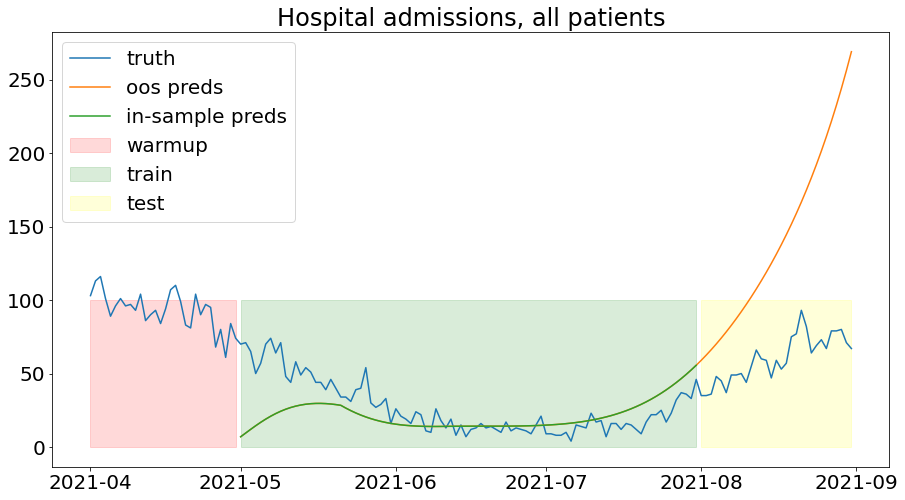

In [104]:
plt.figure(figsize=(15,8))    
plt.plot(df.loc[warmup_start:test_end].index.values,
        df.loc[warmup_start:test_end,'general_ward'].values, label = 'truth')
plt.plot(df.loc[train_start:test_end].index.values,
        test_preds, label = 'oos preds')
plt.plot(df.loc[train_start:train_end].index.values,
        preds, label = 'in-sample preds')
h1 = plt.fill_between(df.loc[warmup_start:warmup_end].index.values, 0, 100,alpha=0.15, color='red',label='warmup')
h2 = plt.fill_between(df.loc[train_start:train_end].index.values, 0, 100,alpha=0.15, color='green', label='train')
h3 = plt.fill_between(df.loc[test_start:test_end].index.values, 0, 100,alpha=0.15, color='yellow', label='test')
plt.legend()

plt.plot()

plt.title('Hospital admissions, all patients')


In [105]:
test_loss

<tf.Tensor: shape=(), dtype=float32, numpy=2196.6782>

In [106]:
test_preds.shape

TensorShape([123])

In [107]:
testing_general_ward.shape

(123,)

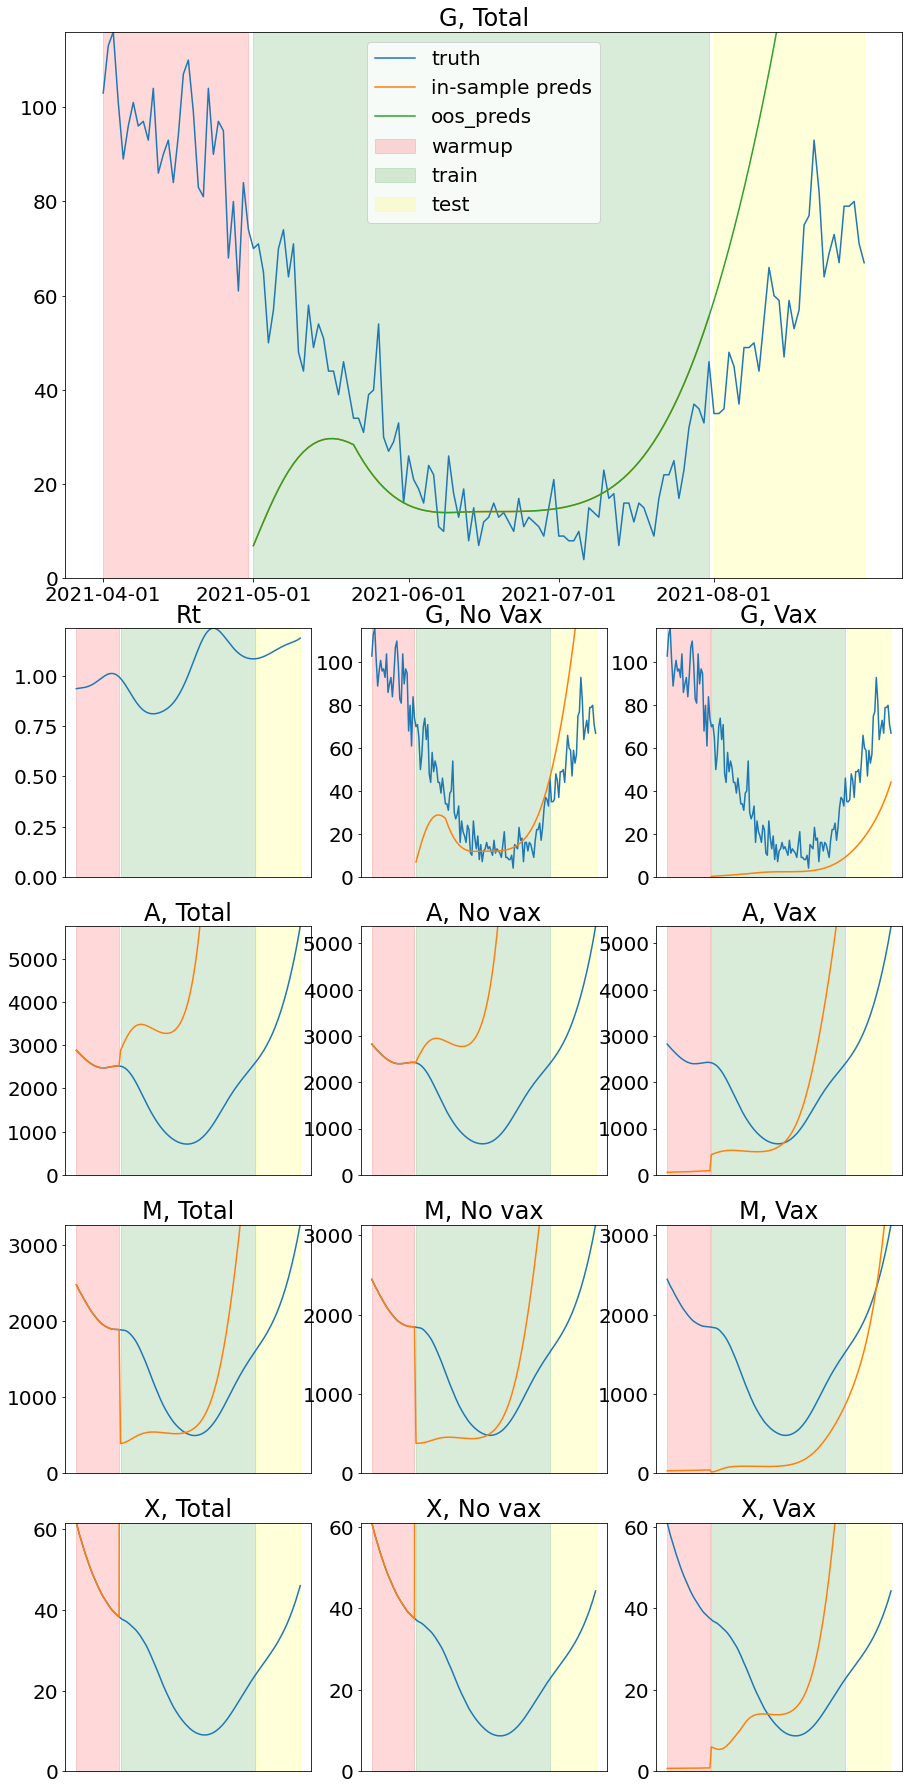

In [108]:
def plot_to_grid(ax, title,in_sample_preds=None,
                 oos_preds=None,
                 truth=None,
                 plot_legend=False, plot_ticks=False):
    
    provided_vals = []
    
    if truth is not None:
        ax.plot(truth[0],
            truth[1], label = 'truth')
        provided_vals += [truth[1]]
        
    if in_sample_preds is not None:
        ax.plot(in_sample_preds[0],
                in_sample_preds[1], label = 'in-sample preds')
        provided_vals += [in_sample_preds[1]]
    if oos_preds is not None:
        ax.plot(oos_preds[0],
                oos_preds[1], label = 'oos_preds')
        provided_vals += [oos_preds[1]]
    
    max_y = max([max(vals) for vals in provided_vals if vals is not None])
    if truth is not None:
        max_y=max(truth[1])

    h1 = ax.fill_between(df.loc[warmup_start:warmup_end].index.values, 0, max_y,alpha=0.15, color='red',label='warmup')
    h2 = ax.fill_between(df.loc[train_start:train_end].index.values, 0, max_y,alpha=0.15, color='green', label='train')
    h3 = ax.fill_between(df.loc[test_start:test_end].index.values, 0, max_y,alpha=0.15, color='yellow', label='test')
    
    if plot_legend:
        ax.legend()
    if plot_ticks:
        month_ticks = matplotlib.dates.MonthLocator(interval=1)
        ax.xaxis.set_major_locator(month_ticks)
        #cut off last tick
        ax.set_xticks(ax.get_xticks()[:-1])
    else:
        ax.set_xticks([])
    
    ax.title.set_text(title)
    ax.set_ylim(0,max_y)

fig =plt.figure(figsize=(15,32))  

ax_hosp_tot = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=2)
ax_rt = plt.subplot2grid((6, 3), (2, 0))
ax_hosp_nonvax = plt.subplot2grid((6, 3), (2, 1))
ax_hosp_vax = plt.subplot2grid((6, 3), (2, 2))
ax_a_tot = plt.subplot2grid((6, 3), (3, 0))
ax_a_nonvax = plt.subplot2grid((6, 3), (3, 1))
ax_a_vax = plt.subplot2grid((6, 3), (3, 2))
ax_m_tot = plt.subplot2grid((6, 3), (4, 0))
ax_m_nonvax = plt.subplot2grid((6, 3), (4, 1))
ax_m_vax = plt.subplot2grid((6, 3), (4, 2))
ax_x_tot = plt.subplot2grid((6, 3), (5, 0))
ax_x_nonvax = plt.subplot2grid((6, 3), (5, 1))
ax_x_vax = plt.subplot2grid((6, 3), (5, 2))

all_days = df.loc[warmup_start:test_end].index.values
train_days = df.loc[train_start:train_end].index.values
test_days = df.loc[test_start:test_end].index.values
train_test_days = df.loc[train_start:test_end].index.values


plot_to_grid(ax_hosp_tot, 'G, Total',
             in_sample_preds=(train_days, preds),
             oos_preds=(train_test_days, test_preds),
             truth=(all_days, 
                    df.loc[warmup_start:test_end,'general_ward'].values),
             plot_legend=True, plot_ticks=True)

plot_to_grid(ax_rt, 'Rt',
             truth=(all_days, df.loc[warmup_start:test_end,'Rt'].values))


plot_to_grid(ax_hosp_nonvax, 'G, No Vax',
             truth=(all_days, df.loc[warmup_start:test_end,'general_ward'].values),
             oos_preds =(train_test_days, forecasted_fluxes[GENERAL_WARD][0].stack().numpy()))
plot_to_grid(ax_hosp_vax, 'G, Vax',
             truth=(all_days, df.loc[warmup_start:test_end,'general_ward'].values),
             oos_preds =(train_test_days, forecasted_fluxes[GENERAL_WARD][1].stack().numpy()))


asymp_vax_all_days = (df.loc[warmup_start:test_end, 'vax_pct'] * (1-vax_asymp_risk) * \
                           df.loc[warmup_start:test_end, 'asymp']).values
asymp_no_vax_all_days = df.loc[warmup_start:test_end, 'asymp'].values - asymp_vax_all_days

mild_vax_all_days = (df.loc[warmup_start:test_end, 'vax_pct'] * (1-vax_mild_risk) * \
                           df.loc[warmup_start:test_end, 'mild']).values
mild_no_vax_all_days = df.loc[warmup_start:test_end, 'mild'].values - mild_vax_all_days

extreme_vax_all_days = (df.loc[warmup_start:test_end, 'vax_pct'] * (1-vax_extreme_risk) * \
                           df.loc[warmup_start:test_end, 'extreme']).values
extreme_no_vax_all_days = df.loc[warmup_start:test_end, 'extreme'].values - extreme_vax_all_days

plot_to_grid(ax_a_tot, 'A, Total',
             truth=(all_days, df.loc[warmup_start:test_end,'asymp'].values),
             oos_preds =(all_days , forecasted_fluxes[ASYMP][0].stack()+forecasted_fluxes[ASYMP][1].stack()))
plot_to_grid(ax_a_nonvax, 'A, No vax',
             truth=(all_days, asymp_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[ASYMP][0].stack()))
plot_to_grid(ax_a_vax, 'A, Vax',
             truth=(all_days, asymp_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[ASYMP][1].stack()))

plot_to_grid(ax_m_tot, 'M, Total',
             truth=(all_days, df.loc[warmup_start:test_end,'mild'].values),
             oos_preds =(all_days , forecasted_fluxes[MILD][0].stack()+forecasted_fluxes[MILD][1].stack()))
plot_to_grid(ax_m_nonvax, 'M, No vax',
             truth=(all_days, mild_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[MILD][0].stack()))
plot_to_grid(ax_m_vax, 'M, Vax',
             truth=(all_days, mild_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[MILD][1].stack()))

plot_to_grid(ax_x_tot, 'X, Total',
             truth=(all_days, df.loc[warmup_start:test_end,'extreme'].values),
             oos_preds =(all_days , forecasted_fluxes[EXTREME][0].stack()+forecasted_fluxes[EXTREME][1].stack()))
plot_to_grid(ax_x_nonvax, 'X, No vax',
             truth=(all_days, extreme_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[EXTREME][0].stack()))
plot_to_grid(ax_x_vax, 'X, Vax',
             truth=(all_days, extreme_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[EXTREME][1].stack()))

   

## Why does A plummet on day 31?

In [109]:
# At_v = (A_no_vax_t-1 + εA_t)*δ_v*RT_t **T_serial^-1

In [110]:
print(f'A_no_vax on last day of warmup: {warmup_asymp[0][-1]}')
print(f'A_vax on last day of warmup: {warmup_asymp[1][-1]}')
print(f'ε: {model.epsilon}')
print(f'δ_no_vax: {model.delta[0]}')
print(f'δ_vax: {model.delta[1]}')
print(f'R_t first day of training: {df.loc[train_start,"Rt"]}')
print(f'1/T_serial {1/T_serial}')

A_no_vax on last day of warmup: 2427.0243423198344
A_vax on last day of warmup: 91.60245667960974
ε: [0.17130977]
δ_no_vax: 1.0
δ_vax: 0.18006280064582825
R_t first day of training: 0.9893858992048348
1/T_serial 0.1724137931034483


In [111]:
(412.3010990316686 + 0.5976*27.050902749677476 )*0.7966195344924927 *1.2356372217235183**(1/T_serial)

354.00656666920656

## Why does X skyrocket on day 31 ??

In [112]:
# X_t_v = Sum over j (X_t-j_v)*rho_v*pi_v

In [113]:
print(f'rho_X_no_vax {model.rho_X[0]}')
print(f'rho_X_vax {model.rho_X[1]}')

rho_X_no_vax 0.16284394264221191
rho_X_vax 0.16494718194007874


In [114]:
print(f'rho_M_no_vax {model.rho_M[0]}')
print(f'rho_M_vax {model.rho_M[1]}')

rho_M_no_vax 0.15549904108047485
rho_M_vax 0.16505113244056702


## What does rho look like compared to prior

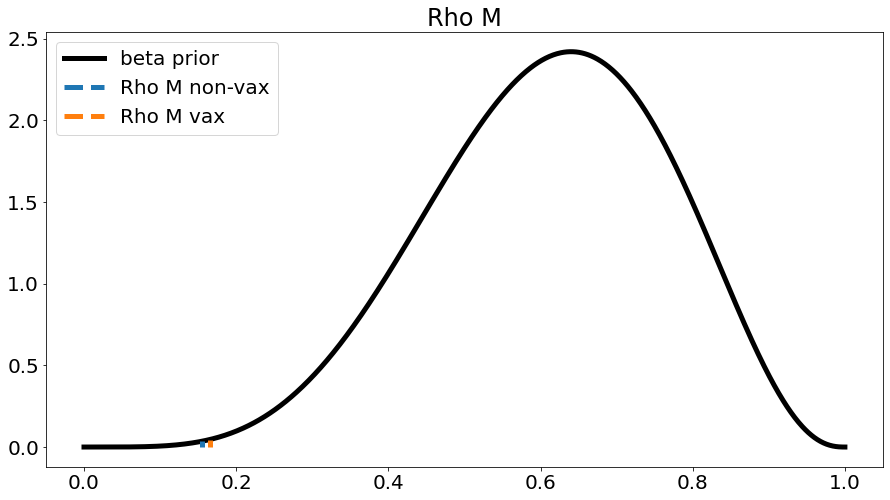

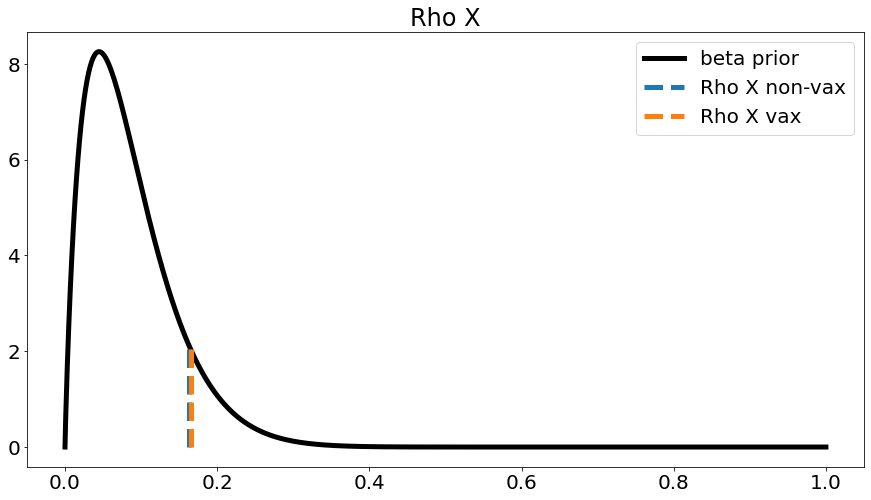

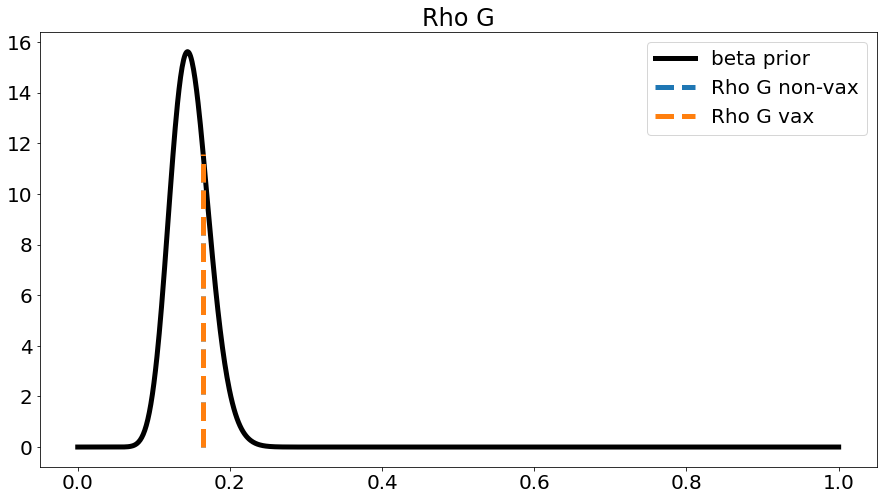

In [115]:
def plot_beta_prior(title, learned_values, alpha_param, beta_param):
    plt.figure(figsize=(15,8))
    x = np.linspace(0,1,1000)
    pdf_vals = beta.pdf(x, alpha_param, beta_param)
    plt.plot(x, pdf_vals,
           'k-', lw=5, label='beta prior');
    plt.plot([learned_values[0], learned_values[0]], [0, beta.pdf(learned_values[0],alpha_param, beta_param)],
             label=f'{title} non-vax',
            linestyle='--', linewidth=5)
    plt.plot([learned_values[1], learned_values[1]], [0, beta.pdf(learned_values[1],alpha_param, beta_param)],
             label=f'{title} vax',
            linestyle='--', linewidth=5)
    plt.legend()
    plt.title(title)


plot_beta_prior('Rho M', model.rho_M, alpha_bar_M, beta_bar_M)
plot_beta_prior('Rho X', model.rho_X, alpha_bar_X, beta_bar_X)
plot_beta_prior('Rho G', model.rho_G, alpha_bar_G, beta_bar_G)


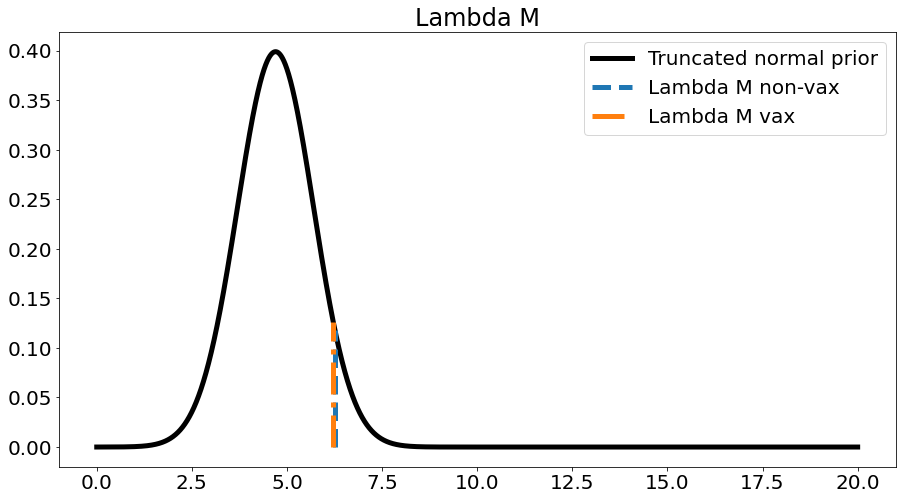

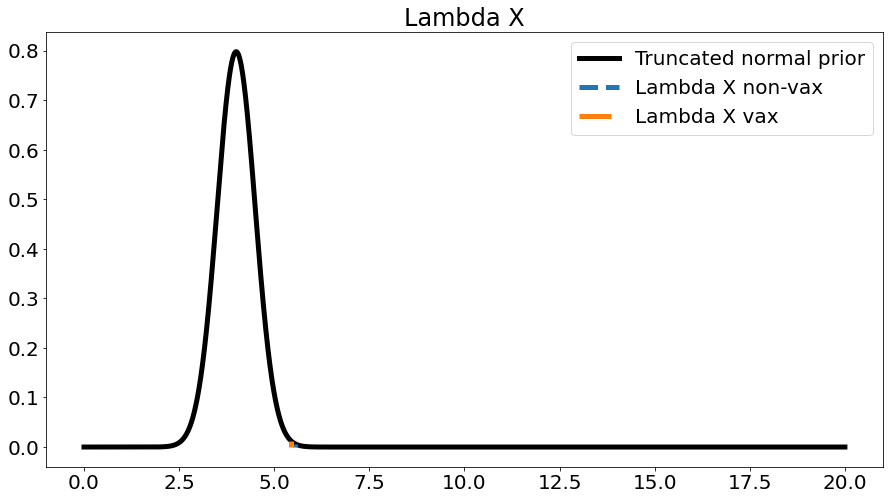

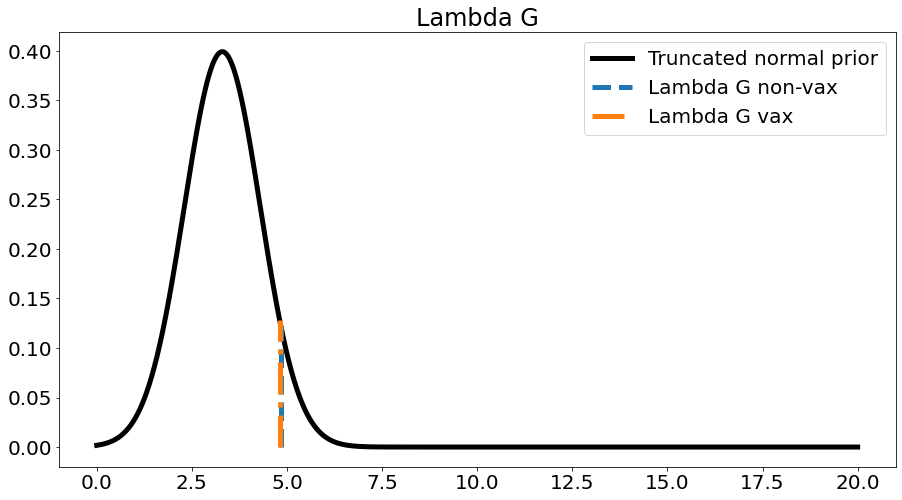

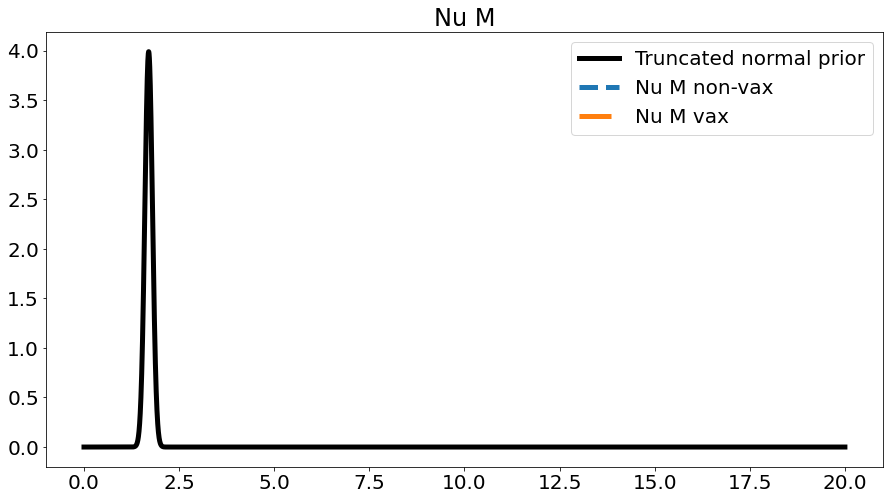

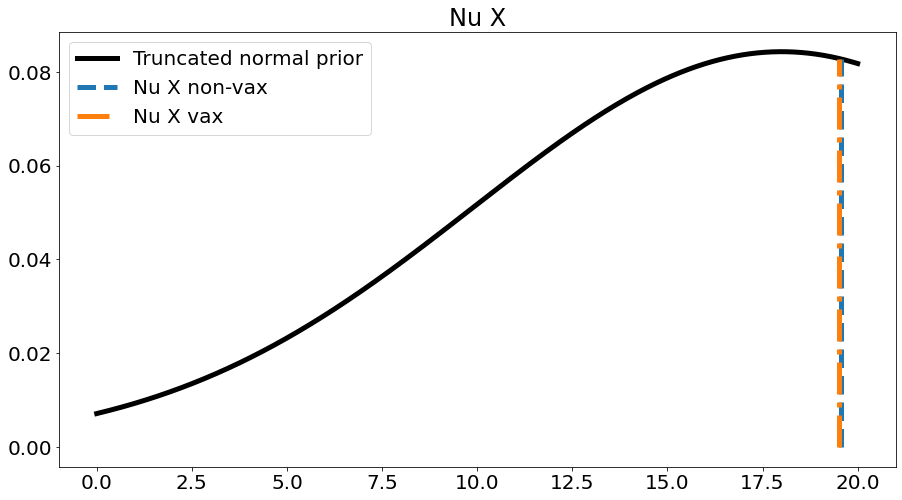

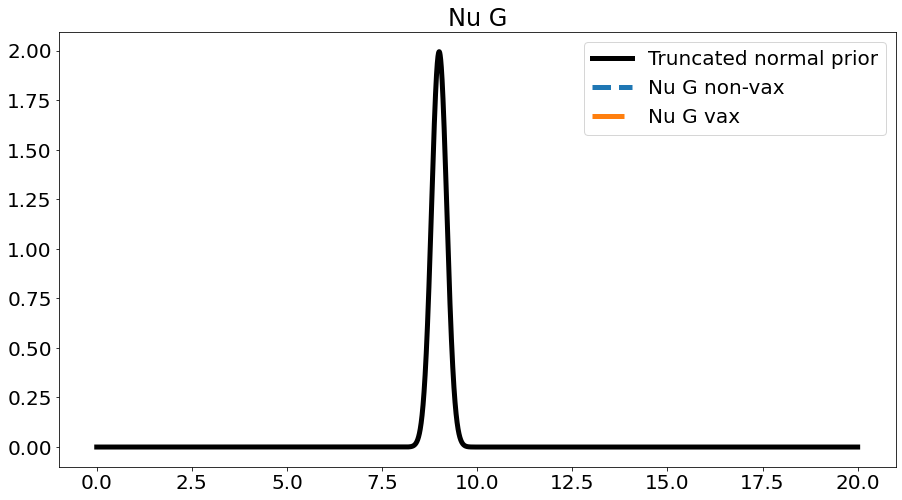

In [116]:
def plot_truncated_normal_prior(title, learned_values, loc_param, scale_param,
                                low=0, high=20):
    
    a = (low - loc_param) / scale_param
    b = (high-loc_param) /scale_param
    
    plt.figure(figsize=(15,8))
    x = np.linspace(low,high,10000)
    pdf_vals = truncnorm.pdf(x, a, b, loc=loc_param, scale=scale_param)
    plt.plot(x, pdf_vals,
           'k-', lw=5, label='Truncated normal prior');
    plt.plot([learned_values[0], learned_values[0]], [0, truncnorm.pdf(learned_values[0], a, b, loc=loc_param, scale=scale_param)],
             label=f'{title} non-vax',
            linestyle='--', linewidth=5)
    plt.plot([learned_values[1], learned_values[1]], [0, truncnorm.pdf(learned_values[1], a, b, loc=loc_param, scale=scale_param)],
             label=f'{title} vax',
            linestyle='-.', linewidth=5)
    plt.legend()
    plt.title(title)


plot_truncated_normal_prior('Lambda M', model.lambda_M, lambda_bar_M, sigma_bar_M)
plot_truncated_normal_prior('Lambda X', model.lambda_X, lambda_bar_X, sigma_bar_X)
plot_truncated_normal_prior('Lambda G', model.lambda_G, lambda_bar_G, sigma_bar_G)

plot_truncated_normal_prior('Nu M', model.nu_M, nu_bar_M, tau_bar_M)
plot_truncated_normal_prior('Nu X', model.nu_X, nu_bar_X, tau_bar_X)
plot_truncated_normal_prior('Nu G', model.nu_G, nu_bar_G, tau_bar_G)


/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


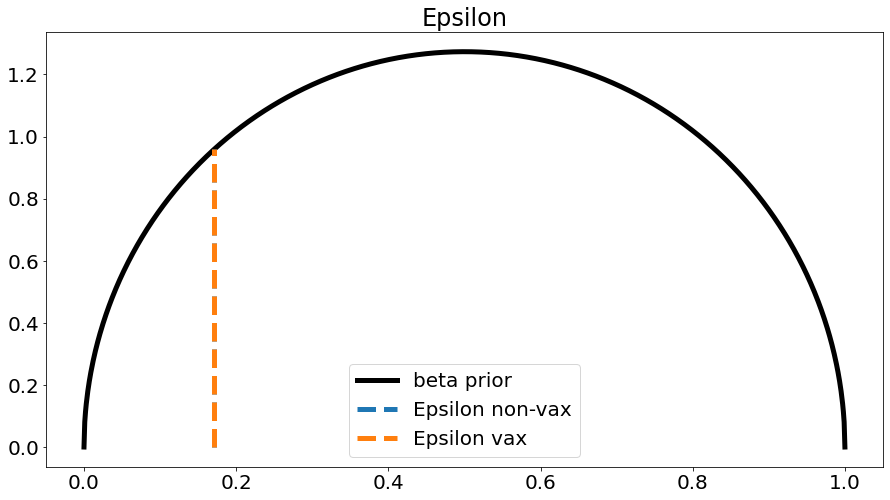

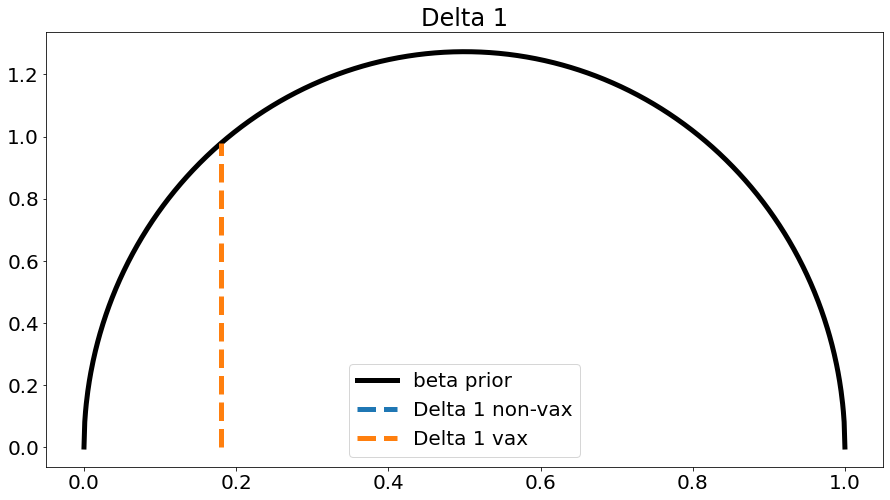

In [117]:
plot_beta_prior('Epsilon', {0: model.epsilon,1:model.epsilon}, 1.5, 1.5)
plot_beta_prior('Delta 1', model.delta, 1.5, 1.5)

In [240]:
x = np.linspace(0,10,1000)
pdf_vals = truncnorm.pdf(x, 0, 100, lambda_bar, sigma_bar)

In [157]:
sigma_bar

1

In [83]:
model.epsilon

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.25554806], dtype=float32)>

In [80]:
model.lambda_M

{0: <tf.Tensor: shape=(), dtype=float32, numpy=4.0814586>,
 1: <tf.Tensor: shape=(), dtype=float32, numpy=4.0368977>}

In [78]:
model.delta[1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.2570846>